# Modeling and Evaluation

## Objectives

* Fit a cluster model to group similar data

## Inputs

* inputs/datasets/raw/house-price-20211124T154130Z-001/house-price/house_prices_records.csv

## Outputs

* Cluster pipeline
* Train Set
* Cluster Description
* Cluster Silhouette

# Change working directory

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/heritage-housing-issues/jupyter_notebooks'

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/heritage-housing-issues'

# Load Data

In [4]:
import numpy as np
import pandas as pd
df = pd.read_csv(f"inputs/datasets/raw/house-price-20211124T154130Z-001/house-price/house_prices_records.csv")
print(df.shape)
df.head(3)

(1460, 24)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500


# Cluster Pipeline

In [5]:
from sklearn.pipeline import Pipeline

from feature_engine.encoding import OrdinalEncoder
from feature_engine import transformation as vt
from feature_engine.selection import DropFeatures
from feature_engine.imputation import  MeanMedianImputer
from feature_engine.imputation import  CategoricalImputer
from feature_engine.imputation import  ArbitraryNumberImputer
from feature_engine.selection import SmartCorrelatedSelection

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans


def PipelineCluster():
    pipeline_base = Pipeline([
        ("DropFeatures", DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF'])),
        ("ArbitraryNumberImputer", ArbitraryNumberImputer(arbitrary_number=0, variables=['MasVnrArea', '2ndFlrSF'])),
        ("CategoricalImputer", CategoricalImputer(imputation_method='missing', fill_value='Unf', variables=['GarageFinish', 'BsmtFinType1'])),
        ("MeanMedianImputer", MeanMedianImputer(imputation_method='median', variables=['LotFrontage', 'BedroomAbvGr', 'GarageYrBlt'])),
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['BsmtExposure','BsmtFinType1','GarageFinish','KitchenQual'])),

        ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(variables=['BsmtUnfSF', 'GarageArea'])),
        ("PowerTransformer", vt.PowerTransformer(variables = ['1stFlrSF','LotArea', 'GrLivArea'], exp=0.5)),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

        ("scaler", StandardScaler()),

        ("PCA", PCA(n_components=50, random_state=0)),

        ("model", KMeans(n_clusters=50, random_state=0)),

    ])

    return pipeline_base

# Principal Component Analysis (PCA)

In [6]:
pipeline_cluster = PipelineCluster()
pipeline_pca = Pipeline(pipeline_cluster.steps[:-2])
df_pca = pipeline_pca.fit_transform(df)

print(df_pca.shape,'\n', type(df_pca))

(1460, 17) 
 <class 'numpy.ndarray'>


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi

We will apply PCA separately to the scaled data using CI function

* The 10 components explain 85.35% of the data 



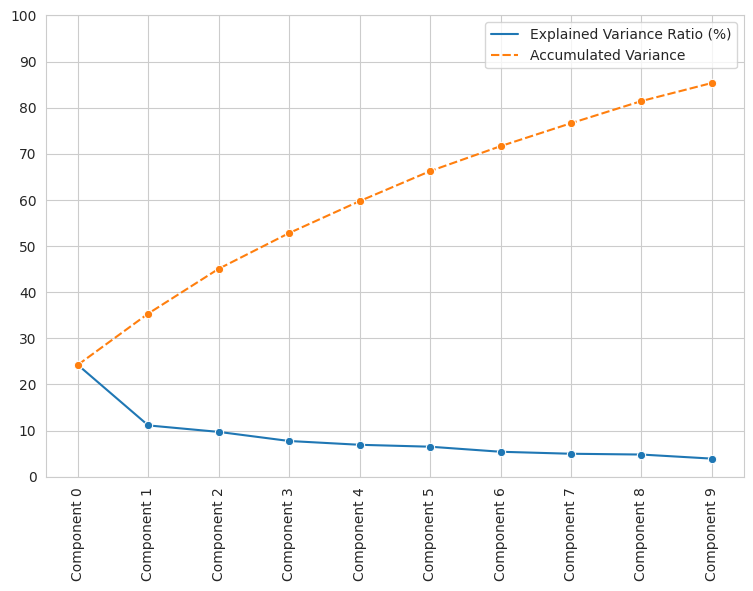

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

n_components = 10


def pca_components_analysis(df_pca, n_components):
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca)

    ComponentsList = ["Component " + str(number)
                      for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data=np.round(100 * pca.explained_variance_ratio_, 3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum(
    )

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum(
    )

    print(
        f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(9, 6))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()


pca_components_analysis(df_pca=df_pca, n_components=n_components)

We are looking to cover at least 95% of the data, let's increase the components

* The 14 components explain 97.28% of the data 



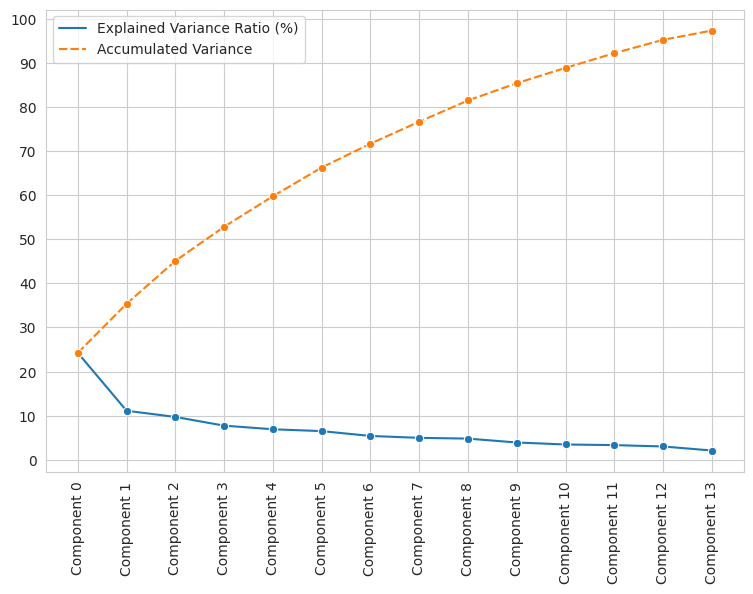

In [8]:
pca_components_analysis(df_pca=df_pca,n_components=14)

Refit the pipeline with the updated components

In [9]:
def PipelineCluster():
    pipeline_base = Pipeline([
        ("DropFeatures", DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF'])),
        ("ArbitraryNumberImputer", ArbitraryNumberImputer(arbitrary_number=0, variables=['MasVnrArea', '2ndFlrSF'])),
        ("CategoricalImputer", CategoricalImputer(imputation_method='missing', fill_value='Unf', variables=['GarageFinish', 'BsmtFinType1'])),
        ("MeanMedianImputer", MeanMedianImputer(imputation_method='median', variables=['LotFrontage', 'BedroomAbvGr', 'GarageYrBlt'])),
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['BsmtExposure','BsmtFinType1','GarageFinish','KitchenQual'])),

        ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(variables=['BsmtUnfSF', 'GarageArea'])),
        ("PowerTransformer", vt.PowerTransformer(variables = ['1stFlrSF','LotArea', 'GrLivArea'], exp=0.5)),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

        ("scaler", StandardScaler()),

        ("PCA", PCA(n_components=14, random_state=0)),

        ("model", KMeans(n_clusters=50, random_state=0)),

    ])

    return pipeline_base

## Elbow Method

We will use elbow method and silhouette score to determine how many clusters we need

In [10]:
pipeline_cluster = PipelineCluster()
pipeline_analysis = Pipeline(pipeline_cluster.steps[:-1])
df_analysis = pipeline_analysis.fit_transform(df)

/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


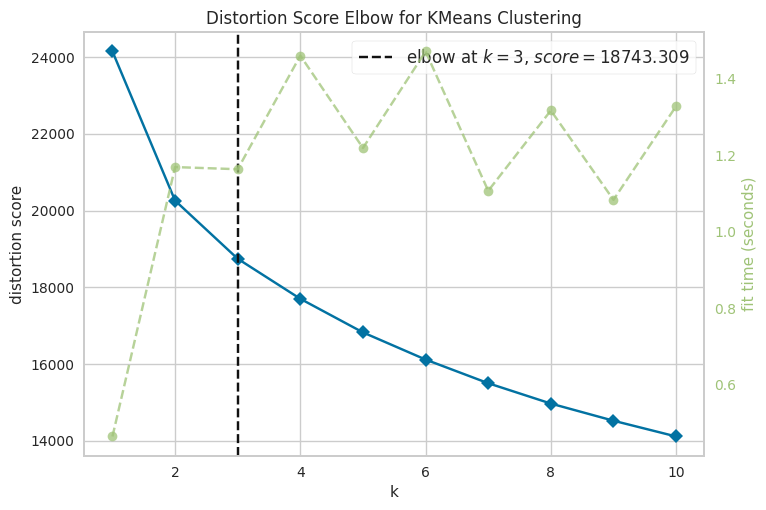

In [11]:
from yellowbrick.cluster import KElbowVisualizer

visualizer = KElbowVisualizer(KMeans(random_state=0), k=(1,11))
visualizer.fit(df_analysis) 
visualizer.show() 
plt.show()

## Silhouette Score

=== Average Silhouette Score for different number of clusters ===


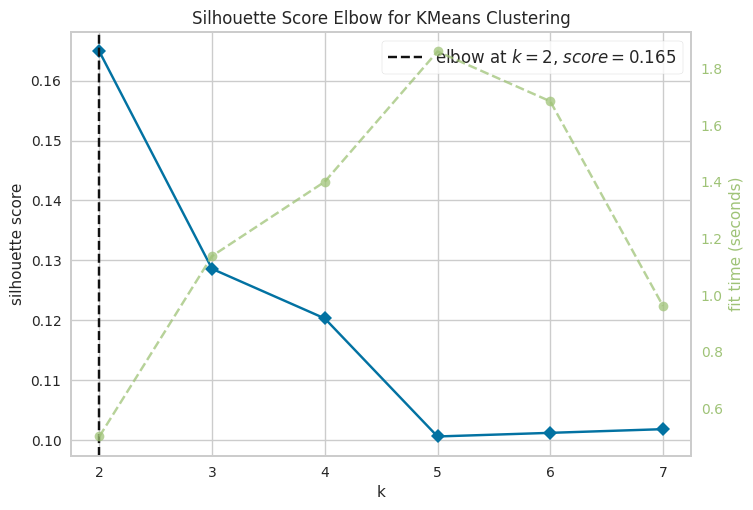



=== Silhouette plot for 2 Clusters ===


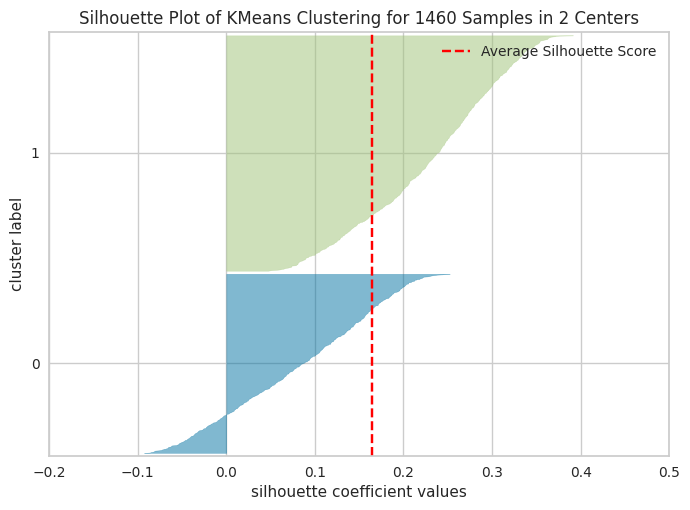



=== Silhouette plot for 3 Clusters ===


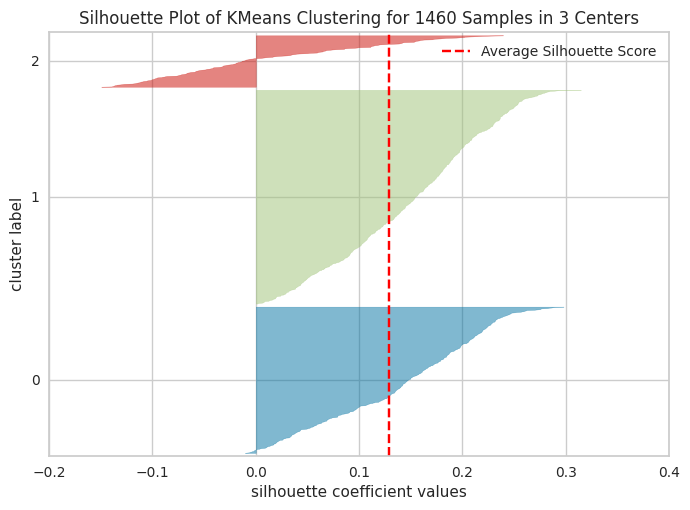



=== Silhouette plot for 4 Clusters ===


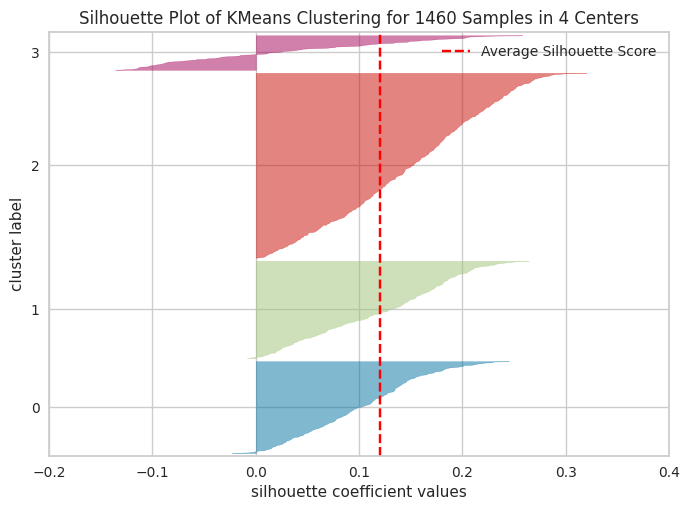



=== Silhouette plot for 5 Clusters ===


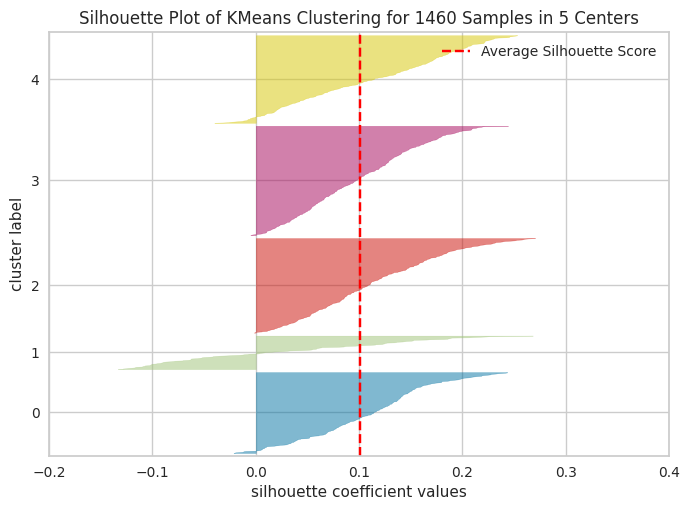



=== Silhouette plot for 6 Clusters ===


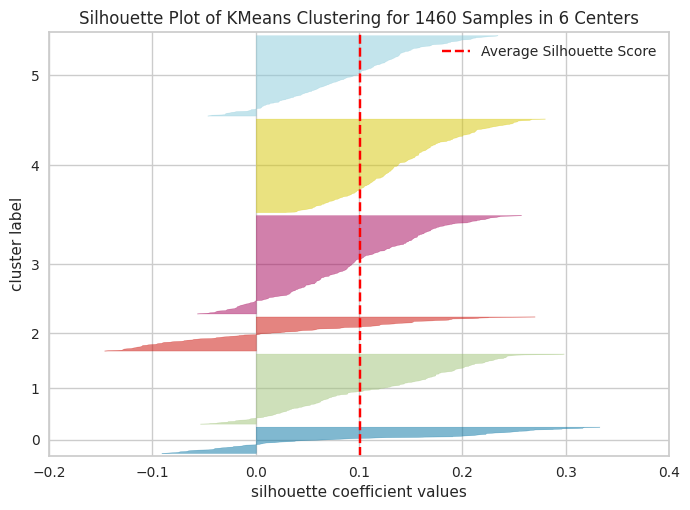



=== Silhouette plot for 7 Clusters ===


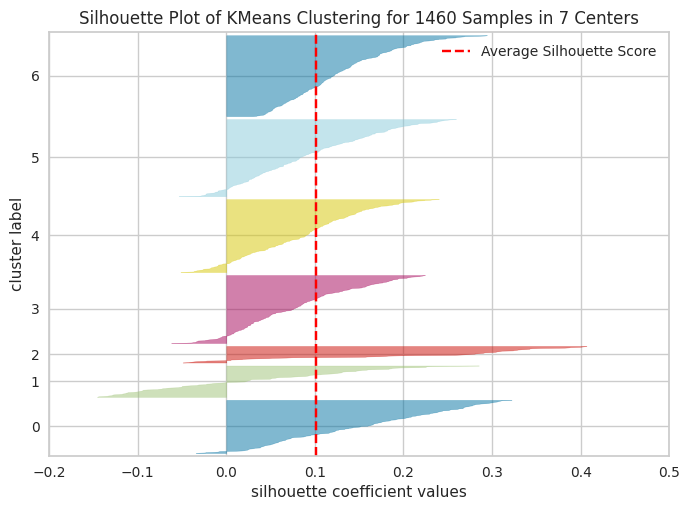

In [12]:
from yellowbrick.cluster import SilhouetteVisualizer

n_cluster_start, n_cluster_stop = 2, 8

print("=== Average Silhouette Score for different number of clusters ===")
visualizer = KElbowVisualizer(KMeans(random_state=0), k=(
    n_cluster_start, n_cluster_stop), metric='silhouette')
visualizer.fit(df_analysis)
visualizer.show()
plt.show()
print("\n")


for n_clusters in np.arange(start=n_cluster_start, stop=n_cluster_stop):

    print(f"=== Silhouette plot for {n_clusters} Clusters ===")
    visualizer = SilhouetteVisualizer(estimator=KMeans(n_clusters=n_clusters, random_state=0),
                                      colors='yellowbrick')
    visualizer.fit(df_analysis)
    visualizer.show()
    plt.show()
    print("\n")

We will pick the most optimal cluster

In [13]:
def PipelineCluster():
    pipeline_base = Pipeline([
        ("DropFeatures", DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF'])),
        ("ArbitraryNumberImputer", ArbitraryNumberImputer(arbitrary_number=0, variables=['MasVnrArea', '2ndFlrSF'])),
        ("CategoricalImputer", CategoricalImputer(imputation_method='missing', fill_value='Unf', variables=['GarageFinish', 'BsmtFinType1'])),
        ("MeanMedianImputer", MeanMedianImputer(imputation_method='median', variables=['LotFrontage', 'BedroomAbvGr', 'GarageYrBlt'])),
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['BsmtExposure','BsmtFinType1','GarageFinish','KitchenQual'])),

        ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(variables=['BsmtUnfSF', 'GarageArea'])),
        ("PowerTransformer", vt.PowerTransformer(variables = ['1stFlrSF','LotArea', 'GrLivArea'], exp=0.5)),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

        ("scaler", StandardScaler()),

        ("PCA", PCA(n_components=14, random_state=0)),

        ("model", KMeans(n_clusters=4, random_state=0)),

    ])

    return pipeline_base

# Fit Cluster Pipeline

In [14]:
X = df.copy()
print(X.shape)
X.head(3)

(1460, 24)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500


In [15]:
pipeline_cluster = PipelineCluster()
pipeline_cluster.fit(X)

/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi

Pipeline(steps=[('DropFeatures',
                 DropFeatures(features_to_drop=['EnclosedPorch',
                                                'WoodDeckSF'])),
                ('ArbitraryNumberImputer',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['MasVnrArea', '2ndFlrSF'])),
                ('CategoricalImputer',
                 CategoricalImputer(fill_value='Unf',
                                    variables=['GarageFinish',
                                               'BsmtFinType1'])),
                ('MeanMedianImputer',
                 MeanMedianImputer(variable...
                                                     'BsmtFinSF1',
                                                     'BsmtFinType1',
                                                     'BsmtUnfSF', 'GarageArea',
                                                     'GarageFinish',
                                                     'GarageYr

# Add cluster predictions to dataset

We add a new column for clusters

In [16]:
X['Clusters'] = pipeline_cluster['model'].labels_
print(X.shape)
X.head(3)

(1460, 25)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice,Clusters
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,196.0,61,5,7,856,0.0,2003,2003,208500,0
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,0.0,0,8,6,1262,NaN,1976,1976,181500,1
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,162.0,42,5,7,920,NaN,2001,2002,223500,0


* Clusters frequencies 
   Clusters
2      0.45
1      0.24
0      0.22
3      0.08 




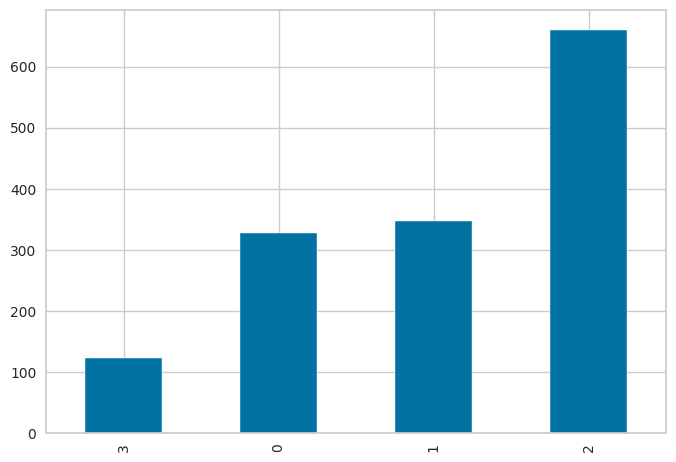

In [17]:
print(f"* Clusters frequencies \n{ X['Clusters'].value_counts(normalize=True).to_frame().round(2)} \n\n")
X['Clusters'].value_counts().sort_values().plot(kind='bar')
plt.show()

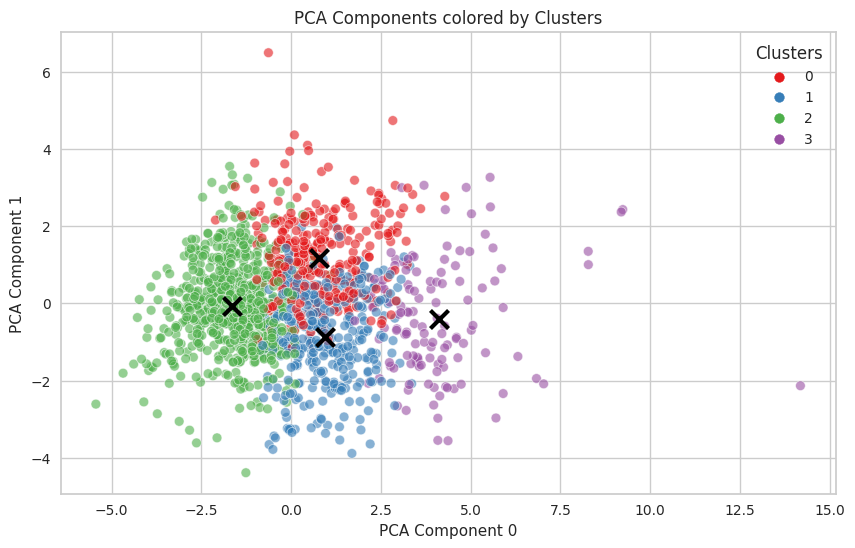

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_analysis[:, 0], y=df_analysis[:, 1],
                hue=X['Clusters'], palette='Set1', alpha=0.6)
plt.scatter(x=pipeline_cluster['model'].cluster_centers_[:, 0], y=pipeline_cluster['model'].cluster_centers_[:, 1],
            marker="x", s=169, linewidths=3, color="black")
plt.xlabel("PCA Component 0")
plt.ylabel("PCA Component 1")
plt.title("PCA Components colored by Clusters")
plt.show()

In [19]:
cluster_predictions_with_all_variables = X['Clusters']
cluster_predictions_with_all_variables

0       0
1       1
2       0
3       2
4       1
       ..
1455    0
1456    1
1457    0
1458    2
1459    2
Name: Clusters, Length: 1460, dtype: int32

# Fit a classifier, where the target is cluster predictions

In [20]:
df_clf = X.copy()
print(df_clf.shape)
df_clf.head(3)

(1460, 25)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice,Clusters
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,196.0,61,5,7,856,0.0,2003,2003,208500,0
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,0.0,0,8,6,1262,NaN,1976,1976,181500,1
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,162.0,42,5,7,920,NaN,2001,2002,223500,0


Split Train and Test set

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df_clf.drop(['Clusters'], axis=1),
    df_clf['Clusters'],
    test_size=0.33,
    random_state=0
)

print(X_train.shape, X_test.shape)

(978, 24) (482, 24)


Now we fit a classifier to clustertarget variable pipeline

In [22]:
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import GradientBoostingClassifier

def PipelineClf():
    pipeline_base = Pipeline([
        ("DropFeatures", DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF'])),
        ("ArbitraryNumberImputer", ArbitraryNumberImputer(arbitrary_number=0, variables=['MasVnrArea', '2ndFlrSF'])),
        ("CategoricalImputer", CategoricalImputer(imputation_method='missing', fill_value='Unf', variables=['GarageFinish', 'BsmtFinType1'])),
        ("MeanMedianImputer", MeanMedianImputer(imputation_method='median', variables=['LotFrontage', 'BedroomAbvGr', 'GarageYrBlt'])),
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['BsmtExposure','BsmtFinType1','GarageFinish','KitchenQual'])),

        ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(variables=['BsmtUnfSF', 'GarageArea'])),
        ("PowerTransformer", vt.PowerTransformer(variables = ['1stFlrSF','LotArea', 'GrLivArea'], exp=0.5)),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

        ("scaler", StandardScaler()),

        ("feat_selection", SelectFromModel(
            GradientBoostingClassifier(random_state=0))),

        ("model", GradientBoostingClassifier(random_state=0)),

    ])

    return pipeline_base

Fit train and test set

In [23]:
pipeline_clf_cluster = PipelineClf()
pipeline_clf_cluster.fit(X_train, y_train)

/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi

Pipeline(steps=[('DropFeatures',
                 DropFeatures(features_to_drop=['EnclosedPorch',
                                                'WoodDeckSF'])),
                ('ArbitraryNumberImputer',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['MasVnrArea', '2ndFlrSF'])),
                ('CategoricalImputer',
                 CategoricalImputer(fill_value='Unf',
                                    variables=['GarageFinish',
                                               'BsmtFinType1'])),
                ('MeanMedianImputer',
                 MeanMedianImputer(variable...
                                                     'GarageFinish',
                                                     'GarageYrBlt', 'GrLivArea',
                                                     'KitchenQual', 'LotArea',
                                                     'LotFrontage',
                                                  

# Evaluate classifier performance

In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_train, pipeline_clf_cluster.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       223
           1       0.98      0.97      0.98       225
           2       0.99      0.99      0.99       444
           3       1.00      1.00      1.00        86

    accuracy                           0.99       978
   macro avg       0.99      0.99      0.99       978
weighted avg       0.99      0.99      0.99       978



In [25]:
print(classification_report(y_test, pipeline_clf_cluster.predict(X_test)))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86       105
           1       0.91      0.80      0.85       123
           2       0.88      0.91      0.90       216
           3       0.73      0.92      0.81        38

    accuracy                           0.87       482
   macro avg       0.85      0.87      0.85       482
weighted avg       0.87      0.87      0.87       482



# Assess the most important Features

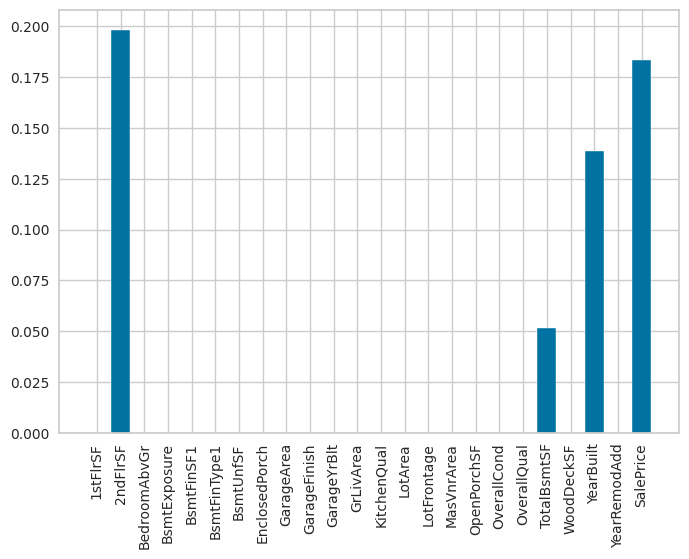

In [38]:
from sklearn.inspection import permutation_importance

feature_importances = permutation_importance(
    pipeline_clf_cluster, X_test, y_test, n_repeats=10, random_state=42
)

features = X_train.columns
best_features = feature_importances.importances_mean

plt.bar(features, importances)
plt.xticks(rotation=90)
plt.show()

In [40]:
def DescriptionAllClusters(df, decimal_points=3):

    DescriptionAllClusters = pd.DataFrame(
        columns=df.drop(['Clusters'], axis=1).columns)
    # iterate on each cluster , calls Clusters_IndividualDescription()
    for cluster in df.sort_values(by='Clusters')['Clusters'].unique():

        EDA_ClusterSubset = df.query(
            f"Clusters == {cluster}").drop(['Clusters'], axis=1)
        ClusterDescription = Clusters_IndividualDescription(
            EDA_ClusterSubset, cluster, decimal_points)
        DescriptionAllClusters = DescriptionAllClusters.append(
            ClusterDescription)

    DescriptionAllClusters.set_index(['Cluster'], inplace=True)
    return DescriptionAllClusters


def Clusters_IndividualDescription(EDA_Cluster, cluster, decimal_points):

    ClustersDescription = pd.DataFrame(columns=EDA_Cluster.columns)
    # for a given cluster, iterate over all columns
    # if the variable is numerical, calculate the IQR: display as Q1 -- Q3.
    # That will show the range for the most common values for the numerical variable
    # if the variable is categorical, count the frequencies and displays the top 3 most frequent
    # That will show the most common levels for the category

    for col in EDA_Cluster.columns:

        try:  # eventually a given cluster will have only missing data for a given variable

            if EDA_Cluster[col].dtypes == 'object':

                top_frequencies = EDA_Cluster.dropna(
                    subset=[col])[[col]].value_counts(normalize=True).nlargest(n=3)
                Description = ''

                for x in range(len(top_frequencies)):
                    freq = top_frequencies.iloc[x]
                    category = top_frequencies.index[x][0]
                    CategoryPercentage = int(round(freq*100, 0))
                    statement = f"'{category}': {CategoryPercentage}% , "
                    Description = Description + statement

                ClustersDescription.at[0, col] = Description[:-2]

            elif EDA_Cluster[col].dtypes in ['float', 'int']:
                DescStats = EDA_Cluster.dropna(subset=[col])[[col]].describe()
                Q1 = round(DescStats.iloc[4, 0], decimal_points)
                Q3 = round(DescStats.iloc[6, 0], decimal_points)
                Description = f"{Q1} -- {Q3}"
                ClustersDescription.at[0, col] = Description

        except Exception as e:
            ClustersDescription.at[0, col] = 'Not available'
            print(
                f"** Error Exception: {e} - cluster {cluster}, variable {col}")

    ClustersDescription['Cluster'] = str(cluster)

    return ClustersDescription

In [41]:
import plotly.express as px


def cluster_distribution_per_variable(df, target):
    """
    The data should have 2 variables, the cluster predictions and
    the variable you want to analyze with, in this case we call "target".
    We use plotly express to create 2 plots:
    Cluster distribution across the target.
    Relative presence of the target level in each cluster.
    """
    df_bar_plot = df.value_counts(["Clusters", target]).reset_index()
    df_bar_plot.columns = ['Clusters', target, 'Count']
    df_bar_plot[target] = df_bar_plot[target].astype('object')

    print(f"Clusters distribution across {target} levels")
    fig = px.bar(df_bar_plot, x='Clusters', y='Count',
                 color=target, width=800, height=500)
    fig.update_layout(xaxis=dict(tickmode='array',
                      tickvals=df['Clusters'].unique()))
    fig.show()

    df_relative = (df
                   .groupby(["Clusters", target])
                   .size()
                   .groupby(level=0)
                   .apply(lambda x:  100*x / x.sum())
                   .reset_index()
                   .sort_values(by=['Clusters'])
                   )
    df_relative.columns = ['Clusters', target, 'Relative Percentage (%)']

    print(f"Relative Percentage (%) of {target} in each cluster")
    fig = px.line(df_relative, x='Clusters', y='Relative Percentage (%)',
                  color=target, width=800, height=500)
    fig.update_layout(xaxis=dict(tickmode='array',
                      tickvals=df['Clusters'].unique()))
    fig.update_traces(mode='markers+lines')
    fig.show()

In [44]:
pd.set_option('display.max_colwidth', None)
clusters_profile = DescriptionAllClusters(df=pd.concat([df_cluster_profile], axis=1), decimal_points=0)
clusters_profile

/tmp/ipykernel_1491/3637392981.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DescriptionAllClusters = DescriptionAllClusters.append(
/tmp/ipykernel_1491/3637392981.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DescriptionAllClusters = DescriptionAllClusters.append(
/tmp/ipykernel_1491/3637392981.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DescriptionAllClusters = DescriptionAllClusters.append(
/tmp/ipykernel_1491/3637392981.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DescriptionAllClusters = DescriptionAllClusters.append(


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
Cluster,,,,,,,,,,,,,,,,,,,,,
0,814.0 -- 1156.0,750.0 -- 1037.0,3.0 -- 4.0,"'No': 77% , 'Av': 10% , 'Mn': 7%",0.0 -- 554.0,"'Unf': 44% , 'GLQ': 33% , 'ALQ': 9%",281.0 -- 847.0,0.0 -- 0.0,434.0 -- 601.0,"'RFn': 41% , 'Fin': 35% , 'Unf': 23%",...,63.0 -- 85.0,0.0 -- 232.0,32.0 -- 104.0,5.0 -- 6.0,6.0 -- 7.0,762.0 -- 1050.0,0.0 -- 144.0,1974.0 -- 2003.0,1991.0 -- 2004.0,174000.0 -- 237250.0
1,1211.0 -- 1578.0,0.0 -- 0.0,2.0 -- 3.0,"'No': 51% , 'Av': 28% , 'Gd': 13%",2.0 -- 917.0,"'GLQ': 51% , 'Unf': 23% , 'ALQ': 19%",307.0 -- 1286.0,0.0 -- 0.0,462.0 -- 602.0,"'RFn': 50% , 'Fin': 27% , 'Unf': 22%",...,56.0 -- 80.0,0.0 -- 182.0,0.0 -- 70.0,5.0 -- 5.0,6.0 -- 7.0,1160.0 -- 1517.0,0.0 -- 143.0,1977.0 -- 2005.0,1983.0 -- 2006.0,165000.0 -- 220000.0
2,832.0 -- 1130.0,0.0 -- 513.0,2.0 -- 3.0,"'No': 73% , 'Av': 9% , 'Mn': 8%",0.0 -- 593.0,"'Unf': 28% , 'BLQ': 18% , 'ALQ': 18%",162.0 -- 674.0,0.0 -- 0.0,252.0 -- 480.0,"'Unf': 69% , 'RFn': 12% , 'None': 11%",...,54.0 -- 74.0,0.0 -- 0.0,0.0 -- 20.0,5.0 -- 7.0,5.0 -- 6.0,691.0 -- 1030.0,0.0 -- 164.0,1930.0 -- 1966.0,1951.0 -- 1994.0,109500.0 -- 144000.0
3,1504.0 -- 1982.0,0.0 -- 880.0,2.0 -- 3.0,"'Gd': 35% , 'No': 31% , 'Av': 26%",806.0 -- 1386.0,"'GLQ': 79% , 'Unf': 14% , 'ALQ': 5%",310.0 -- 870.0,0.0 -- 0.0,660.0 -- 843.0,"'Fin': 75% , 'RFn': 23% , 'Unf': 3%",...,78.0 -- 99.0,204.0 -- 558.0,45.0 -- 120.0,5.0 -- 5.0,8.0 -- 9.0,1499.0 -- 1958.0,171.0 -- 214.0,1998.0 -- 2007.0,2002.0 -- 2008.0,292308.0 -- 392983.0
